# Sprint 15: Computer Vision Project

# Contents <a id='back'></a>

* [Introduction](#introduction)
* [Data Overview](#data_overview)
    * [Initialization](#initialization)
    * [Load Data](load_data)
* [EDA](#eda)
    * [Explore Age Distribution](#age_distribution)   
    * [Sample Photos](#sample_photos)
    * [Findings](#findings)
* [Modelling](#modelling)
    * [Prepare the Script to Run on the GPU Platform](#gpu)   
    * [Output](#output)
    * [Model Analysis](#model_analysis)
* [Conclusion](#conclusion)

# Introduction <a id='introduction'></a>

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
Computer vision methods can be used to determine age of a person from a photo
The task then is to build and evaluate a model for verifying people's age
A set of photographs of people with their ages indicated have been provided.

[Back to Contents](#back)

# Data Overview <a id='data_overview'></a>

## Initialization <a id='initialization'></a> <a class="tocSkip">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, AvgPool2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Load Data <a id='load_data'></a> <a class="tocSkip">

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


The dataset contains 7591 images

## EDA  <a id='eda'></a> <a class="tocSkip">

###  Explore Age Distribution <a id='age_distribution'></a> <a class="tocSkip">

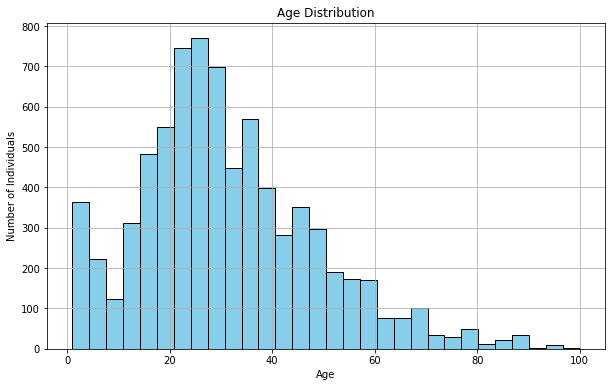

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Individuals')
plt.grid(True)
plt.show()

The plot dislpays a right-skewed distribution, except for the images of young children also having a higher frequecy.

### Sample Photos <a id='sample_photos'></a> <a class="tocSkip">

Images for age 10:


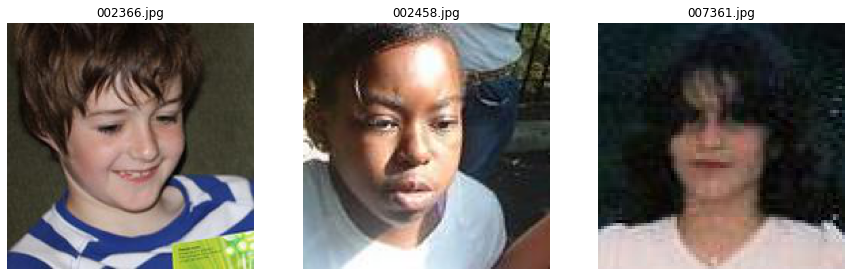

Images for age 20:


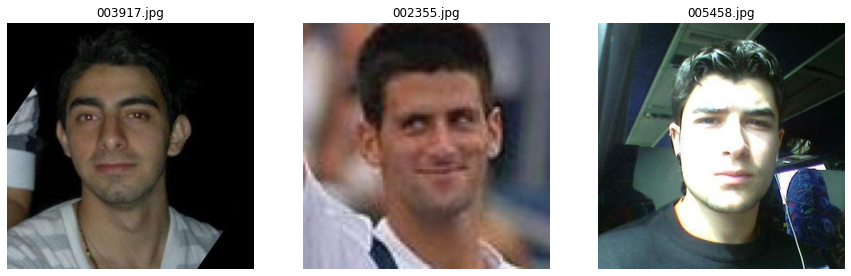

Images for age 30:


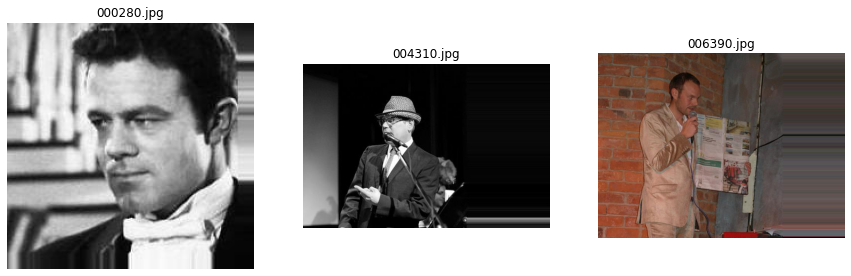

Images for age 40:


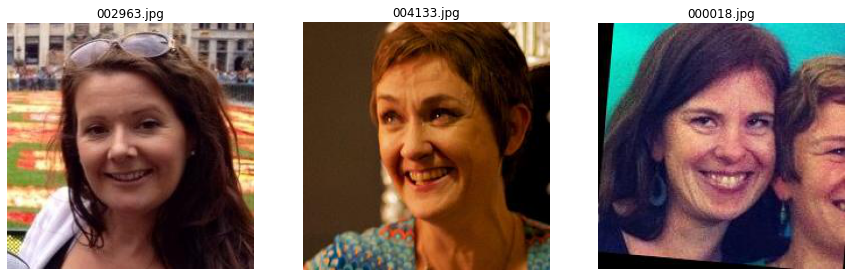

Images for age 50:


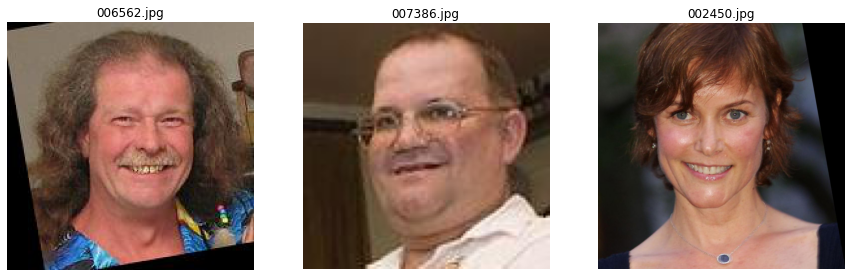

Images for age 60:


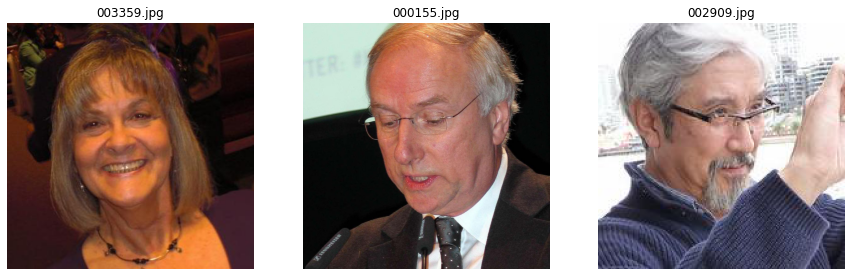

Images for age 70:


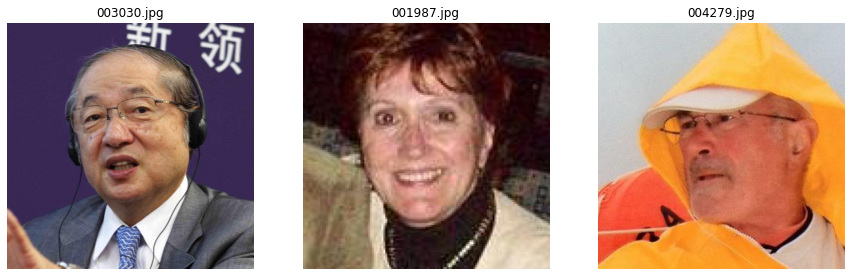

In [5]:
age_groups = [10, 20, 30, 40, 50, 60, 70]
num_photos_per_age = 3  # Number of photos to print per age

for age in age_groups:
    age_samples = labels[labels['real_age'] == age].sample(num_photos_per_age)
    print(f"Images for age {age}:")
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(age_samples.iterrows()):
        img_path = '/datasets/faces/final_files/' + row['file_name']
        img = load_img(img_path)
        plt.subplot(1, num_photos_per_age, i + 1)
        plt.imshow(img)
        plt.title(row['file_name'])
        plt.axis('off')
    plt.show()

### Findings <a id='findings'></a> <a class="tocSkip">

Understanding the dataset size helps in determining computational resources required for training and evaluating the model. As the number of image files is rather high, instead of reading them all at once, which would be resource consuming, it was read sequentially with the ImageDataGenerator generator. A larger dataset generally leads to better model performance, but it also requires more computational resources and longer training times.

Examining the age distribution helps in understanding the distribution of age labels in the dataset, which is crucial for model performance, especially if the dataset is imbalanced. The plot dislpays a right-skewed distribution, except for the images of young children also having a higher frequecy. This skewed distribution shows an age bias in data collection, though it is common to have more images of adults than children in publicly available datasets due to privacy concerns and ease of data acquisition. This bias can affect the model's ability to generalize well, especially for age groups with fewer samples.

The presence of more data points for older ages compared to younger ages suggests that the model might have less training data to learn representations for younger age groups. This could pose challenges in accurately predicting ages for children and infants.

The skewed distribution may lead to variations in model performance across different age groups. The model might perform well for age groups with sufficient data but struggle with age groups that have fewer samples.

When evaluating the model, it's essential to consider metrics beyond overall accuracy, such as age-specific performance metrics or metrics that account for class imbalance. This ensures a more comprehensive understanding of the model's capabilities across different age groups.

If there's a significant imbalance in age distribution, the model might be biased towards more frequent age groups. Techniques like data augmentation, class weights, or oversampling can mitigate this.

Viewing sample photos for different ages gives an impression of the data quality, diversity, and potential challenges the model may face. It was observed from the sample images that they seem qualitatively accurate, though not all images are high quality images and are blurry or pixelated which can have an impact on the accuracy of the model. Poor quality images or inconsistent labeling can affect model performance. Data cleaning and preprocessing steps might be necessary. Also if the dataset lacks diversity in terms of age, ethnicity, or other factors, the model may not generalize well to unseen data. Augmentation techniques and diverse datasets can help improve generalization.

# Modeling <a id='modelling'></a> <a class="tocSkip">

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [6]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.2
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow

In [7]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.2
    )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_gen_flow

In [8]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    model = Sequential()
    model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation=None)) 

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    # Compile the model with the desired optimizer
    optimizer = Adam(lr=0.0001)  # Example learning rate, adjust as needed
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2  # Set verbose to 2 to print one line per epoch
    )
    
    return model, history

## Prepare the Script to Run on the GPU Platform <a id='gpu'></a> <a class="tocSkip">

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [10]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

## Output <a id='output'></a> <a class="tocSkip">

Place the output from the GPU platform as an Markdown cell here.

```python

2024-04-03 20:54:38.338419: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-04-03 20:54:38.409342: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2024-04-03 20:54:42.094224: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-04-03 20:54:42.180960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 20:54:42.181162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-04-03 20:54:42.181202: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-04-03 20:54:42.181235: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-03 20:54:42.272983: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-04-03 20:54:42.286994: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-04-03 20:54:42.477607: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-04-03 20:54:42.498595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-04-03 20:54:42.498673: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-04-03 20:54:42.498778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 20:54:42.499009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 20:54:42.499175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-04-03 20:54:42.499510: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-04-03 20:54:42.525835: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300085000 Hz
2024-04-03 20:54:42.528856: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x34000d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-04-03 20:54:42.528902: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-04-03 20:54:42.658578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 20:54:42.658859: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x123e720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 20:54:42.658880: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-04-03 20:54:42.659115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 20:54:42.659300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-04-03 20:54:42.659340: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-04-03 20:54:42.659352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-03 20:54:42.659381: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-04-03 20:54:42.659409: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-04-03 20:54:42.659442: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-04-03 20:54:42.659466: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-04-03 20:54:42.659479: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-04-03 20:54:42.659544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 20:54:42.659756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 20:54:42.659902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-04-03 20:54:42.660940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-04-03 20:54:44.103963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-04-03 20:54:44.104002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-04-03 20:54:44.104012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-04-03 20:54:44.105138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 20:54:44.105392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 20:54:44.105562: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-03 20:54:44.105608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 0s
 5767168/94765736 [>.............................] - ETA: 0s
13049856/94765736 [===>..........................] - ETA: 0s
22831104/94765736 [======>.......................] - ETA: 0s
32309248/94765736 [=========>....................] - ETA: 0s
37355520/94765736 [==========>...................] - ETA: 0s
48955392/94765736 [==============>...............] - ETA: 0s
55558144/94765736 [================>.............] - ETA: 0s
60735488/94765736 [==================>...........] - ETA: 0s
65175552/94765736 [===================>..........] - ETA: 0s
67870720/94765736 [====================>.........] - ETA: 0s
73515008/94765736 [======================>.......] - ETA: 0s
80510976/94765736 [========================>.....] - ETA: 0s
89079808/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 380 steps, validate for 95 steps
Epoch 1/20
2024-04-03 20:54:59.307680: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-03 20:55:00.852538: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 59s - loss: 10.9659 - mae: 10.9685 - val_loss: 18.9933 - val_mae: 18.9886
Epoch 2/20
380/380 - 35s - loss: 8.0017 - mae: 8.0077 - val_loss: 10.5407 - val_mae: 10.5405
Epoch 3/20
380/380 - 35s - loss: 6.9212 - mae: 6.9193 - val_loss: 8.5254 - val_mae: 8.5272
Epoch 4/20
380/380 - 35s - loss: 6.1944 - mae: 6.1963 - val_loss: 7.0617 - val_mae: 7.0598
Epoch 5/20
380/380 - 35s - loss: 5.4809 - mae: 5.4831 - val_loss: 6.7793 - val_mae: 6.7794
Epoch 6/20
380/380 - 35s - loss: 5.1570 - mae: 5.1567 - val_loss: 7.1436 - val_mae: 7.1446
Epoch 7/20
380/380 - 35s - loss: 4.8364 - mae: 4.8364 - val_loss: 6.5944 - val_mae: 6.5975
Epoch 8/20
380/380 - 35s - loss: 4.6792 - mae: 4.6781 - val_loss: 7.4477 - val_mae: 7.4483
Epoch 9/20
380/380 - 35s - loss: 4.5720 - mae: 4.5724 - val_loss: 7.3016 - val_mae: 7.3020
Epoch 10/20
380/380 - 35s - loss: 4.3789 - mae: 4.3799 - val_loss: 7.7240 - val_mae: 7.7234
Epoch 11/20
380/380 - 35s - loss: 4.2550 - mae: 4.2560 - val_loss: 6.9010 - val_mae: 6.8979
Epoch 12/20
380/380 - 36s - loss: 4.2205 - mae: 4.2215 - val_loss: 6.6284 - val_mae: 6.6269
Epoch 13/20
380/380 - 35s - loss: 4.0799 - mae: 4.0818 - val_loss: 6.3470 - val_mae: 6.3454
Epoch 14/20
380/380 - 35s - loss: 3.9775 - mae: 3.9771 - val_loss: 6.4596 - val_mae: 6.4596
Epoch 15/20
380/380 - 35s - loss: 3.9792 - mae: 3.9812 - val_loss: 6.7263 - val_mae: 6.7240
Epoch 16/20
380/380 - 35s - loss: 3.8838 - mae: 3.8819 - val_loss: 6.4604 - val_mae: 6.4617
Epoch 17/20
380/380 - 35s - loss: 3.8939 - mae: 3.8955 - val_loss: 6.7713 - val_mae: 6.7727
Epoch 18/20
380/380 - 35s - loss: 3.7568 - mae: 3.7567 - val_loss: 6.8357 - val_mae: 6.8343
Epoch 19/20
380/380 - 35s - loss: 3.7613 - mae: 3.7616 - val_loss: 6.1758 - val_mae: 6.1764
Epoch 20/20
380/380 - 35s - loss: 3.5833 - mae: 3.5834 - val_loss: 6.3410 - val_mae: 6.3417
                
```

The model's MAE score is 6.3417, passing the requirements of having an MAE of less than 8. The MAE represents the average absolute deviation of the predicted ages from the true ages. In this case, an MAE of approximately 6.3417 suggests that the model's predictions are reasonably close to the true ages but still have room for improvement.

## Model Analysis <a id='model_analysis'></a> <a class="tocSkip">

Computer vision can indeed help the customer in the scenario of age verification for alcohol sales. By utilizing computer vision algorithms to analyze images captured by cameras in the checkout area, the customer can automate the process of verifying customers' ages before allowing them to purchase alcohol. This can help the customer comply with alcohol laws and regulations, reducing the risk of selling alcohol to underage individuals and potential legal consequences.

Additionally, the model developed for age verification can be adapted to solve various other practical tasks for the customer. Some potential applications include:

Identity Verification: Beyond age verification for alcohol sales, the model can be utilized for general identity verification purposes. This can include verifying the identity of individuals for access to restricted areas, membership validation, or secure transactions.

Customer Insights and Personalization: By analyzing customer demographics, such as age and gender, from checkout area images, the customer can gain valuable insights into their customer base. This information can be used to personalize marketing strategies, tailor product offerings, and enhance customer experience.

Loss Prevention and Security: Computer vision can be employed for real-time monitoring of the checkout area to detect and prevent theft or fraudulent activities. The model can identify suspicious behaviors, such as unauthorized item scanning or tampering with products, and alert store personnel for intervention.

Queue Management: By analyzing checkout area images, the customer can monitor queue lengths and customer flow in real-time. This information can be used to optimize staffing levels, improve checkout efficiency, and enhance customer satisfaction.

Product Placement and Shelf Management: Computer vision algorithms can analyze images to assess product availability, monitor shelf conditions, and optimize product placement strategies. This can help ensure that shelves are well-stocked, products are properly displayed, and popular items are readily accessible to customers.

Customer Service and Assistance: By integrating computer vision technology with interactive displays or mobile applications, the customer can offer enhanced customer service and assistance. For example, the model can analyze customer facial expressions to gauge satisfaction levels and provide personalized recommendations or assistance based on customer needs.

Overall, computer vision technology offers a wide range of practical applications for businesses beyond age verification, enabling them to enhance operational efficiency, improve customer experience, and drive business growth.

# Conclusions <a id='conclusion'></a> <a class="tocSkip">

In this project, we aimed to explore the potential of data science in assisting the Good Seed supermarket chain to adhere to alcohol laws by preventing the sale of alcohol to underage individuals. Utilizing computer vision methods, we endeavored to build and evaluate a model for verifying people's ages based on photographs captured by cameras in the checkout area.

Our exploratory data analysis (EDA) revealed several key insights regarding the dataset provided. Firstly, we observed a right-skewed age distribution, with the exception of a higher frequency of images depicting young children. This skewness in distribution, common in publicly available datasets, indicates an age bias in data collection, with more images of adults than children, potentially impacting the model's ability to generalize well across different age groups.

Additionally, we noted that the model might have less training data to learn representations for younger age groups, which could pose challenges in accurately predicting ages for children and infants. Furthermore, the skewed distribution may result in variations in model performance across different age groups, with the model potentially biased towards more frequent age groups.

During model evaluation, we emphasized the importance of considering metrics beyond overall accuracy, such as age-specific performance metrics, to gain a comprehensive understanding of the model's capabilities across different age groups. Furthermore, we highlighted the necessity of data augmentation techniques, class weights adjustments, or oversampling to mitigate age distribution imbalances and improve model performance.

Despite qualitative observations indicating reasonably accurate sample images, we noted the presence of poor-quality images, including blurry or pixelated images, which could impact model accuracy. Consequently, data cleaning and preprocessing steps, as well as augmentation techniques and diverse datasets, were recommended to enhance model generalization.

Finally, our model achieved a Mean Absolute Error (MAE) of approximately 6.3417 during evaluation. This MAE signifies a reasonable level of accuracy in predicting true ages. While there is always room for improvement, the passing MAE of less than 8 was achieved for this project.